In [1]:
# Load the necessary Python packages for the analysis.
%matplotlib inline

import os

import datacube
import datacube.utils.rio
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import rgb
from deafrica_tools.spatial import xr_rasterize
from scipy import stats

# This will speed up loading data
datacube.utils.rio.set_default_rio_config(aws="auto", cloud_defaults=True)

In [2]:
# Set up a Dask cluster.
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:38969 Dashboard: /user/nanaboamah89@gmail.com/proxy/8787/status,Cluster Workers: 1 Cores: 4 Memory: 28.14 GB


In [3]:
# Connect to the datacube to access DE Africa data.
# The `app` parameter is a unique name for the analysis which is based on the notebook file name.
dc = datacube.Datacube(app="NDVI_Classification")

In [4]:
# Set important parameters for the analysis.

# Set the bands/measurements of the satellite data to load.
measurements = ["red", "green", "blue", "nir"]

# Set the time period of interest for your analysis.
time_range = ("2014", "2019")

# Set the x and y cell resolution of the satellite data.
# If loading a large area, then increase the resolution so the data will fit into memory.
resolution = (-120, 120)

# Set the Coordinate Reference System (CRS) the satellite data is to be reprojected to.
output_crs = "EPSG:6933"

dask_chunks = dict(x=1000, y=1000)

# Create the output directory to store the results.
output_dir = "results"
os.makedirs(output_dir, exist_ok=True)

In [5]:
# Load the African Countries GeoJSON.
# This file contains polygons for the boundaries of African countries.
african_countries = gpd.read_file("../Supplementary_data/MGCI/african_countries.geojson")

# List the countries in the African Countries GeoJSON.
np.unique(african_countries["COUNTRY"])

array(['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso',
       'Burundi', 'Cameroon', 'Cape Verde', 'Central African Republic',
       'Chad', 'Comoros', 'Congo-Brazzaville', 'Cote d`Ivoire',
       'Democratic Republic of Congo', 'Djibouti', 'Egypt',
       'Equatorial Guinea', 'Eritrea', 'Ethiopia', 'Gabon', 'Gambia',
       'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia',
       'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Morocco',
       'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda',
       'Sao Tome and Principe', 'Senegal', 'Sierra Leone', 'Somalia',
       'South Africa', 'Sudan', 'Swaziland', 'Tanzania', 'Togo',
       'Tunisia', 'Uganda', 'Western Sahara', 'Zambia', 'Zimbabwe'],
      dtype=object)

In [6]:
# Select an African country to carry out the analysis over.
country = "Burkina Faso"

# The country selected needs to be transformed into a geometry object to be used in the dc.load() function.
idx = african_countries[african_countries["COUNTRY"] == country].index[0]
geom = Geometry(geom=african_countries.iloc[idx].geometry, crs=african_countries.crs)

In [7]:
# Create a reusable datacube query object.
query = {
    "geopolygon": geom,
    "time": time_range,
    "resolution": resolution,
    "output_crs": output_crs,
    "dask_chunks": dask_chunks,
}

In [8]:
# Load available Landsat 8 Annual GeoMAD data.
ds = dc.load(
    product="gm_ls8_annual", measurements=["red", "green", "blue", "nir"], **query
)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 6, y: 5905, x: 6372)
Coordinates:
  * time         (time) datetime64[ns] 2014-07-02T11:59:59.999999 ... 2019-07...
  * y            (y) float64 1.903e+06 1.902e+06 ... 1.194e+06 1.194e+06
  * x            (x) float64 -5.325e+05 -5.324e+05 ... 2.319e+05 2.32e+05
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


In [9]:
# Mask the Landsat GeoMAD dataset with the country polygon.
african_countries = african_countries.to_crs(output_crs)
mask = xr_rasterize(african_countries[african_countries["COUNTRY"] == country], ds)
ds = ds.where(mask)

In [10]:
# Calculate the NDVI spectral index and add it to the loaded Landsat GeoMAD dataset.
ds = calculate_indices(ds, "NDVI", satellite_mission="ls")
# Get the NDVI xarray.DataArray.
ds_ndvi = ds.NDVI.compute()

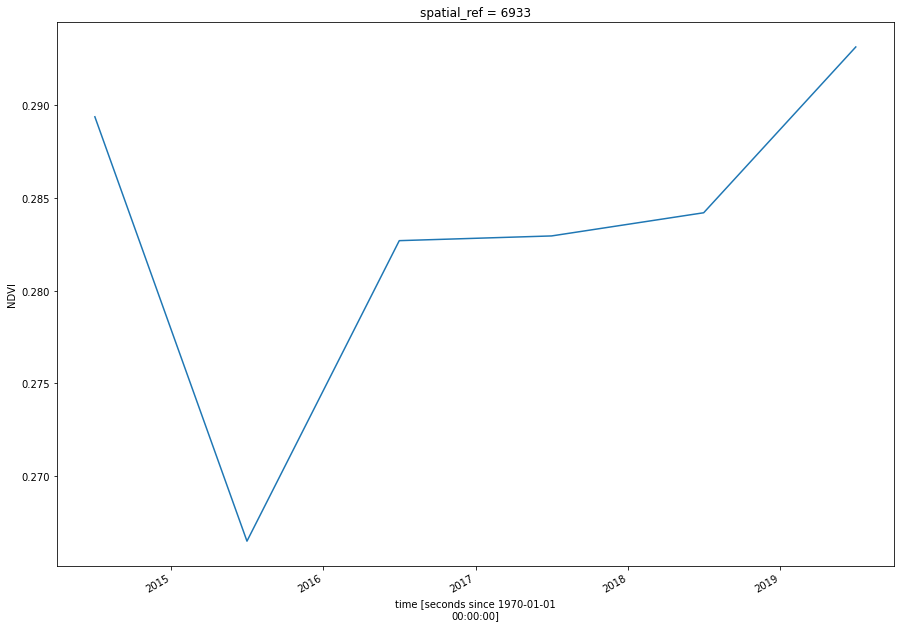

In [20]:
ds_ndvi.mean(dim=['x','y']).plot(size=10)

In [11]:
# Define the name and class values of the NDVI Classes.
ndvi_classes = ["Very Low", "Low", "Normal", "High", "Very High"]
ndvi_class_values = [1, 2, 3, 4, 5]

classification_condition = [
    (ds_ndvi > -1) & (ds_ndvi <= 0.16),
    (ds_ndvi > 0.16) & (ds_ndvi <= 0.30),
    (ds_ndvi > 0.30) & (ds_ndvi <= 0.50),
    (ds_ndvi > 0.50) & (ds_ndvi <= 0.66),
    (ds_ndvi > 0.66) & (ds_ndvi <= 1),
]


ds_ndvi_classified = (
    xr.DataArray(
        np.select(classification_condition, ndvi_class_values),
        coords={"time": ds_ndvi.time, "y": ds_ndvi.y, "x": ds_ndvi.x},
        dims=["time", "y", "x"],
    )
    .astype(ds_ndvi.dtype)
    .where(mask)
)

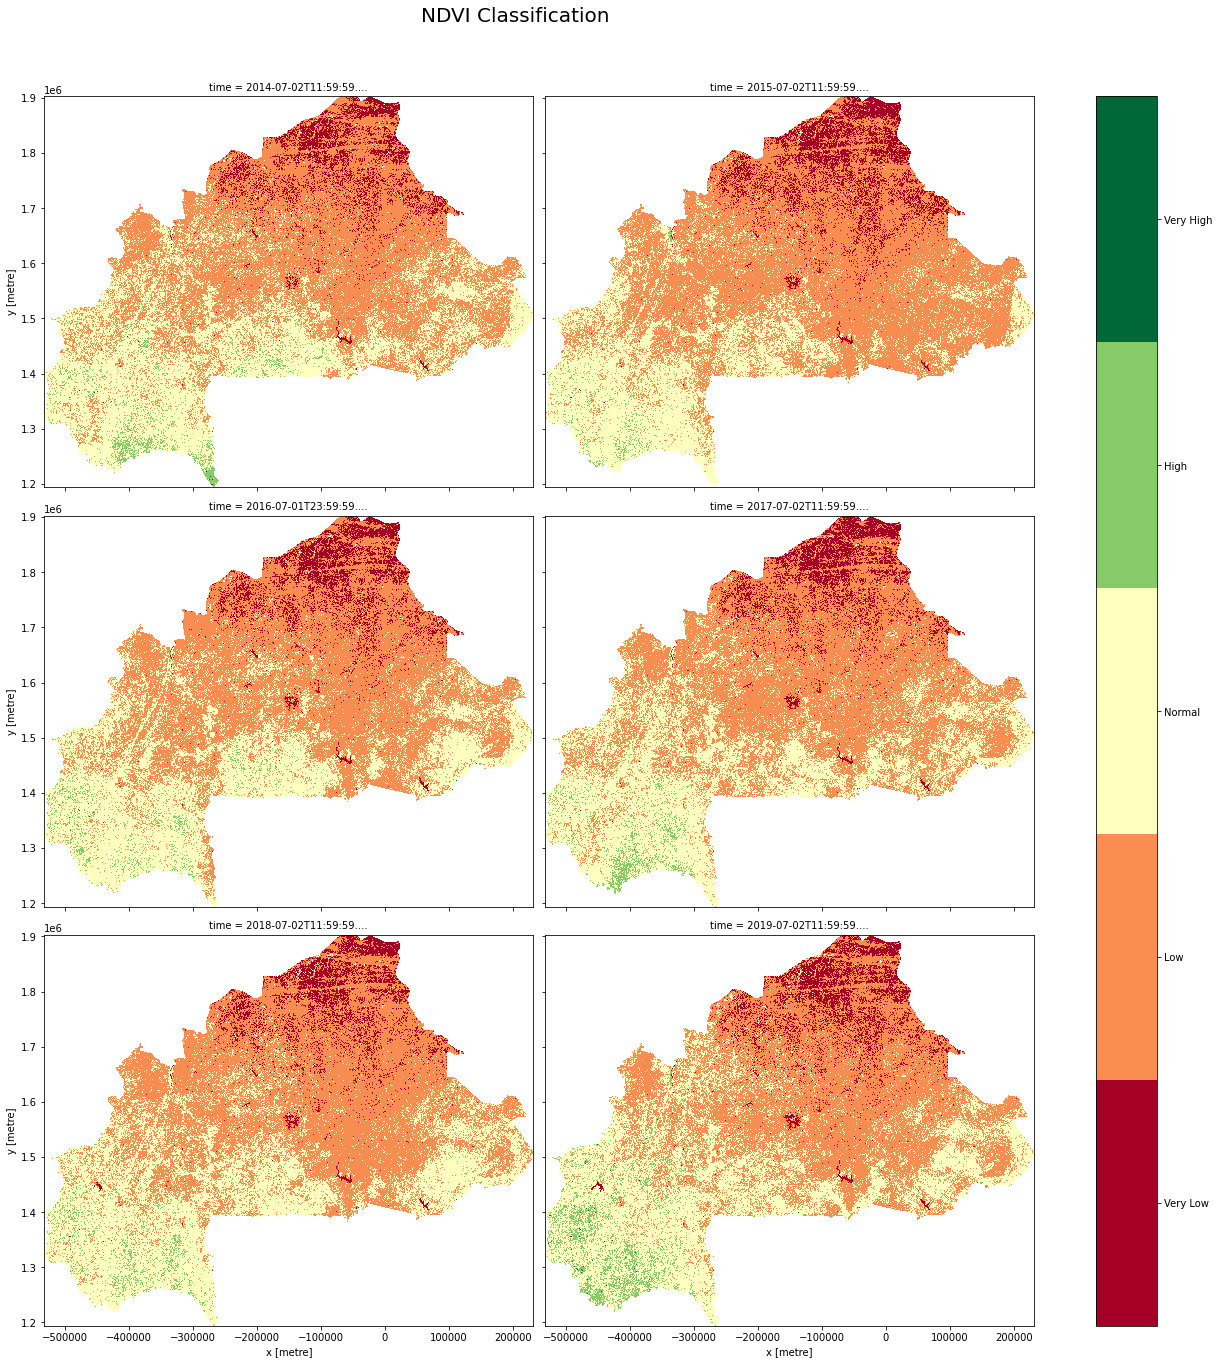

In [12]:
# Define the NDVI classification specific color map.
cmap = plt.get_cmap("RdYlGn", len(ndvi_class_values))
bounds = np.arange(min(ndvi_class_values) - 0.5, max(ndvi_class_values) + 1, 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Visualise the NDVI classification.
fig = ds_ndvi_classified.plot.imshow(
    col="time", col_wrap=2, cmap=cmap, norm=norm, add_colorbar=False, figsize=(18, 18)
)

fig.fig.suptitle("NDVI Classification", x=0.4, y=1.05, size=20)
cbar = plt.colorbar(fig._mappables[-1], ax=fig.axes, ticks=ndvi_class_values)
cbar.set_ticklabels(ndvi_classes)
plt.savefig(f"results/{country}_NDVI_classification.png")
plt.show()